Read files. Contents for train:
UD_Dutch-LassySmall:
['# archive = nl_lassysmalldevelop-ud-train.collection\n', '# source = LassyDevelop/wiki-1058/wiki-1058.p.10.s.1.xml\n']
UD_Polish-PDB:
['# sent_id = train-s1\n', '# text = Mężczyzna w czapce z daszkiem trzyma w rękach kamerę i spogląda przez obiektyw.\n']
UD_Turkish-Kenet:
['# sent_id = 0001.train\n', '# text = Üstünde lacivert abajurlu , parlak bir madenden lamba .\n']
UD_Italian-ISDT:
['# newdoc = tanl\n', '# sent_id = isst_tanl-1\n']
UD_Norwegian-Bokmaal:
['# sent_id = 000001\n', '# text = Lam og piggvar på bryllupsmenyen\n']
UD_Ancient_Greek-PTNK:
['# sent_id = Septuagint-Genesis-31:1-grc\n', '# text = ἤκουσεν δὲ Ἰακὼβ τὰ ῥήματα τῶν υἱῶν Λαβὰν λεγόντων, εἴληφεν Ἰακὼβ πάντα τὰ τοῦ πατρὸς ἡμῶν καὶ ἐκ τῶν τοῦ πατρὸς ἡμῶν πεποίηκεν πᾶσαν τὴν δόξαν ταύτην.\n']
UD_Slovak-SNK:
['# sent_id = blogsme:2005-09-21-d-199:2005-09-21-d-199-p1s2\n', '# text = Kde tá ľudská duša drieme?\n']
UD_Russian-Taiga:
['# sent_id = taiga-train-social-2\n'

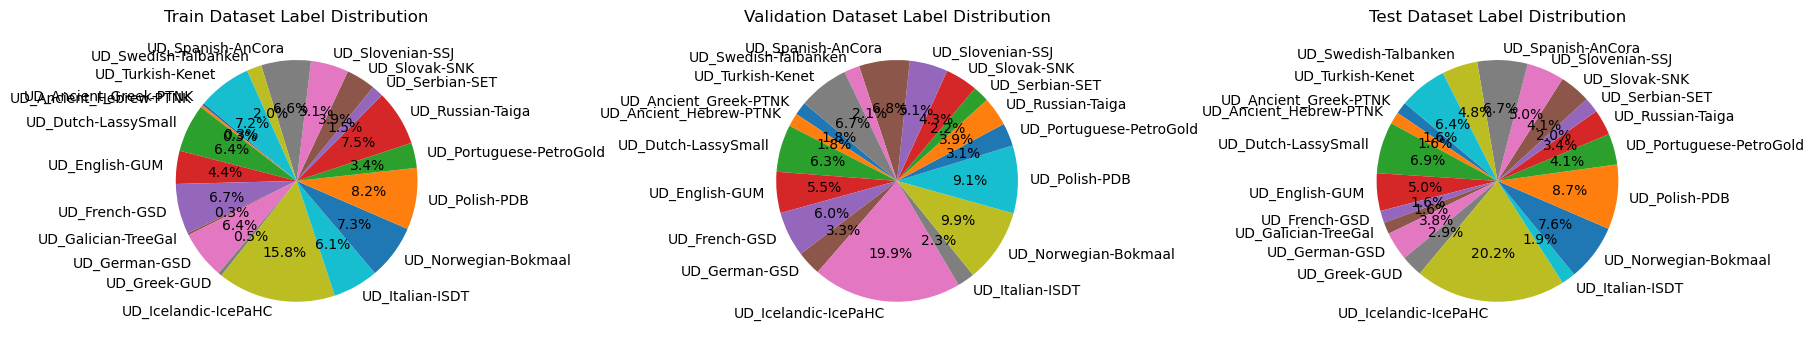

In [1]:
import os
from dataUtils import *
from charFreq import *

# Set the path to the directory containing the datasets
dataset_path = 'data/'

# Call the function and get the contents of all .conllu files
conllu_files = readConnluFiles(dataset_path)

# Call the function with the conllu_files dictionary
texts_by_file_type = extractTexts(conllu_files)

# Generate labeled datasets
labeled_datasets = createLabeledDataset(texts_by_file_type)

# Assuming labeled_datasets contains 'train', 'dev', 'test' data structured as before
plotLabelDistributions(labeled_datasets)

Label inequalities will be a problem troughout this process

In [ ]:
n_grams = [1, 2, 3]  # Unigrams, bigrams, trigrams
similarity_metrics = ['kl_divergence', 'jensen_shannon', 'cosine', 'euclidean'] # 'cosine', 'euclidean', 'max_inner_product', 'manhattan', 'jaccard', 'kl_divergence', 'jensen_shannon'
n_words = [10, 20, 30, 40, 50]
run_all_tests(texts_by_file_type, n_grams=n_grams, similarity_metrics=similarity_metrics, n_words_list=n_words) 

In [ ]:
n_grams = [3]  # Unigrams, bigrams, trigrams
similarity_metrics = ['jensen_shannon'] # 'cosine', 'euclidean', 'max_inner_product', 'manhattan', 'jaccard', 'kl_divergence', 'jensen_shannon'
n_words = [15]
run_all_tests(texts_by_file_type, n_grams=n_grams, similarity_metrics=similarity_metrics, n_words_list=n_words) 

### NAIVE BAYES:

Naive bayes is useful in the way that it learns the repeating trends(n-grams), and learns which n-grams are more related with which language.
If there are a lot of 'ing', 'the', 'ion' in a document it is highly likely it can be English.
What is missing in naive bayes is order of n-grams does not matter.

In [7]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
    ('classifier', MultinomialNB())
])

# Get the training data
X_train = labeled_datasets['train']['sentences']
y_train = labeled_datasets['train']['labels']

# Fit the model
pipeline.fit(X_train, y_train)

# Get the test data
X_test = labeled_datasets['test']['sentences']
y_test = labeled_datasets['test']['labels']

# Predict the test data
y_pred = pipeline.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

  UD_Ancient_Greek-PTNK       1.00      1.00      1.00       410
 UD_Ancient_Hebrew-PTNK       1.00      1.00      1.00       410
    UD_Dutch-LassySmall       0.98      0.94      0.96      1761
         UD_English-GUM       0.97      0.95      0.96      1285
          UD_French-GSD       0.89      1.00      0.94       416
    UD_Galician-TreeGal       1.00      0.07      0.14       400
          UD_German-GSD       0.94      0.98      0.96       977
           UD_Greek-GUD       1.00      1.00      1.00       736
   UD_Icelandic-IcePaHC       1.00      0.99      0.99      5157
        UD_Italian-ISDT       0.91      0.99      0.95       482
   UD_Norwegian-Bokmaal       0.98      0.98      0.98      1939
          UD_Polish-PDB       1.00      1.00      1.00      2215
UD_Portuguese-PetroGold       0.92      0.98      0.95      1061
       UD_Russian-Taiga       1.00      0.99      0.99       881
         UD_Serbian-SET 

## FEATURE EXTRACTION

In [4]:
import re

def word_occurrence_rate(text, word_list):
    words = text.lower().split()
    word_count = sum(word in word_list for word in words)
    return word_count / len(words) if words else 0


def extract_language_features(text):
    features = {}
    
    # Character set features
    features['has_latin'] = int(bool(re.search(r'[a-zA-Z]', text)))
    features['has_cyrillic'] = int(bool(re.search(r'[\u0400-\u04FF]', text)))
    features['has_greek'] = int(bool(re.search(r'[\u0370-\u03FF]', text)))
    features['has_arabic'] = int(bool(re.search(r'[\u0600-\u06FF]', text)))
    features['has_hebrew'] = int(bool(re.search(r'[\u0590-\u05FF]', text)))
    features['has_cjk'] = int(bool(re.search(r'[\u4E00-\u9FFF]', text)))
    features['has_hiragana'] = int(bool(re.search(r'[\u3040-\u309F]', text)))
    features['has_katakana'] = int(bool(re.search(r'[\u30A0-\u30FF]', text)))
    features['has_hangul'] = int(bool(re.search(r'[\uAC00-\uD7AF]', text)))
    
    # Specific character features
    features['has_tilde_n'] = int('ñ' in text.lower())
    features['has_eszett'] = int('ß' in text)
    features['has_eth'] = int('ð' in text.lower())
    features['has_thorn'] = int('þ' in text.lower())
    features['has_ae_ligature'] = int('æ' in text.lower())
    features['has_oe_ligature'] = int('œ' in text.lower())
    
    # Diacritic features
    features['has_acute'] = int(bool(re.search(r'[áéíóúýÁÉÍÓÚÝ]', text)))
    features['has_grave'] = int(bool(re.search(r'[àèìòùÀÈÌÒÙ]', text)))
    features['has_circumflex'] = int(bool(re.search(r'[âêîôûÂÊÎÔÛ]', text)))
    features['has_umlaut'] = int(bool(re.search(r'[äëïöüÄËÏÖÜ]', text)))
    features['has_tilde'] = int(bool(re.search(r'[ãõñÃÕÑ]', text)))
    
    # Common digraphs
    digraphs = ['ch', 'sh', 'th', 'ph', 'qu', 'ck', 'ng', 'gh']
    for digraph in digraphs:
        features[f'has_{digraph}'] = int(digraph in text.lower())
    
    # Word ending features
    features['words_ending_vowel'] = len(re.findall(r'\b\w+[aeiou]\b', text.lower()))
    features['words_ending_consonant'] = len(re.findall(r'\b\w+[bcdfghjklmnpqrstvwxyz]\b', text.lower()))
    
    # Specific language features
    features['has_french_contractions'] = int(bool(re.search(r"\b[lcdjmnst]'", text.lower())))
    features['has_german_umlauts'] = int(bool(re.search(r'[äöüÄÖÜ]', text)))
    features['has_spanish_inverted_punctuation'] = int('¿' in text or '¡' in text)
    features['has_scandinavian_aa'] = int('å' in text.lower())
    features['has_dutch_ij'] = int('ij' in text.lower())
    
    # 
    features['non_alphabetic_presence'] = sum(1 for char in text if not char.isalpha()) / len(text) if text else 0
    
    # 
    features['avg_word_length'] = sum(len(word) for word in text.split()) / len(text.split()) if text.split() else 0
    
    # What is the ratio of question marks and exclamation points to total end punctuation?
    total_end_punctuation = text.count('.') + text.count('?') + text.count('!')
    question_exclamation = text.count('?') + text.count('!')
    features['question_exclamation_ratio'] = question_exclamation / total_end_punctuation if total_end_punctuation else 0
    
    # What is the ratio of vowels to consonants?
    vowels = sum(1 for char in text.lower() if char in 'aeiou')
    consonants = sum(1 for char in text.lower() if char.isalpha() and char not in 'aeiou')
    features['vowel_consonant_ratio'] = vowels / consonants if consonants else 0
    
    # What is the ratio of repeated characters to total characters?
    pattern = r'(\w)\1{2,}'
    repeats = re.findall(pattern, text)
    features['repeated_characters'] = len(repeats) / len(text) if text else 0
    
    # Most common words in different languages
    languages = ['English', 'French', 'German', 'Ancient Greek', 'Ancient Hebrew', 'Dutch', 'Galician', 'Greek', 'Icelandic', 'Italian', 'Korean', 'Norwegian', 'Polish', 'Portuguese', 'Russian', 'Serbian', 'Slovak', 'Slovenian', 'Spanish', 'Swedish', 'Turkish']
    word_lists = [
        ['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'I', 'it'],
        ['le', 'la', 'les', 'de', 'être', 'un', 'une', 'avoir', 'il', 'ne', 'ce'],
        ['der', 'die', 'das', 'und', 'ein', 'eine', 'in', 'werden', 'haben', 'zu', 'mit', 'im', 'ihr'],
        ['και', 'ο', 'η', 'το', 'τον', 'της', 'των', 'τους', 'να', 'δεν', 'είναι'],
        ['את', 'על', 'לא', 'כי', 'אל', 'אשר', 'כל', 'בני', 'עם', 'גם', 'יהוה'],
        ['de', 'het', 'een', 'en', 'van', 'in', 'is', 'te', 'dat', 'op', 'voor'],
        ['o', 'de', 'que', 'e', 'a', 'en', 'un', 'non', 'para', 'con', 'por'],
        ['και', 'να', 'το', 'που', 'τη', 'της', 'για', 'με', 'στο', 'δεν', 'από'],
        ['og', 'að', 'í', 'á', 'sem', 'er', 'til', 'um', 'var', 'með', 'ekki'],
        ['di', 'e', 'che', 'a', 'il', 'per', 'un', 'in', 'con', 'non', 'è'],
        ['는', '은', '이', '가', '을', '를', '의', '에', '로', '과', '와'],
        ['og', 'i', 'å', 'på', 'det', 'er', 'som', 'en', 'for', 'til', 'av'],
        ['i', 'w', 'na', 'się', 'z', 'do', 'nie', 'że', 'to', 'o', 'a'],
        ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'para', 'com', 'um'],
        ['и', 'в', 'не', 'на', 'я', 'быть', 'он', 'с', 'что', 'а', 'по'],
        ['и', 'у', 'да', 'је', 'се', 'на', 'за', 'не', 'што', 'то', 'од'],
        ['a', 'sa', 'na', 'že', 'je', 'to', 'v', 'ako', 'tak', 'by', 'si'],
        ['in', 'je', 'se', 'da', 'na', 'za', 'ki', 'so', 'v', 'ne', 'bi'],
        ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'se', 'del', 'las'],
        ['och', 'att', 'det', 'som', 'en', 'på', 'är', 'för', 'av', 'med', 'i'],
        ['ve', 'bir', 'bu', 'da', 'de', 'için', 'ben', 'ne', 'olmak', 'çok', 'ile']
    ]
    
    for lang, word_list in zip(languages, word_lists):
        features[f'{lang}_word_rate'] = word_occurrence_rate(text, word_list)
    
    return features

In [5]:
# Fetch the labeled data
X_train = labeled_datasets['train']['sentences']
y_train = labeled_datasets['train']['labels']
X_test = labeled_datasets['test']['sentences']
y_test = labeled_datasets['test']['labels']

# Test the feature extraction function
sample_text = X_train[100]
features = extract_language_features(sample_text)
print(f"Number of features: {len(features)}")
print(f"Sample features: {list(features.items())[:-10]}")

Number of features: 61
Sample features: [('has_latin', 1), ('has_cyrillic', 0), ('has_greek', 0), ('has_arabic', 0), ('has_hebrew', 0), ('has_cjk', 0), ('has_hiragana', 0), ('has_katakana', 0), ('has_hangul', 0), ('has_tilde_n', 0), ('has_eszett', 0), ('has_eth', 0), ('has_thorn', 0), ('has_ae_ligature', 0), ('has_oe_ligature', 0), ('has_acute', 0), ('has_grave', 1), ('has_circumflex', 0), ('has_umlaut', 0), ('has_tilde', 0), ('has_ch', 1), ('has_sh', 0), ('has_th', 0), ('has_ph', 0), ('has_qu', 0), ('has_ck', 0), ('has_ng', 0), ('has_gh', 0), ('words_ending_vowel', 6), ('words_ending_consonant', 23), ('has_french_contractions', 0), ('has_german_umlauts', 0), ('has_spanish_inverted_punctuation', 0), ('has_scandinavian_aa', 0), ('has_dutch_ij', 0), ('non_alphabetic_presence', 0.16279069767441862), ('avg_word_length', 5.967741935483871), ('question_exclamation_ratio', 0.0), ('vowel_consonant_ratio', 0.6981132075471698), ('repeated_characters', 0.0), ('English_word_rate', 0.06451612903225

## XGBOOST

In [13]:
import re
from collections import Counter
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
X_train = labeled_datasets['train']['sentences']
y_train = labeled_datasets['train']['labels']
X_test = labeled_datasets['test']['sentences']
y_test = labeled_datasets['test']['labels']

# Extract features
X_train_features = [extract_language_features(text) for text in X_train]
X_test_features = [extract_language_features(text) for text in X_test]

# Convert features to numpy arrays
X_train_array = np.array([[feat[key] for key in sorted(feat.keys())] for feat in X_train_features])
X_test_array = np.array([[feat[key] for key in sorted(feat.keys())] for feat in X_test_features])

# Add character n-gram features
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=1000)
X_train_ngrams = vectorizer.fit_transform(X_train).toarray()
X_test_ngrams = vectorizer.transform(X_test).toarray()

# Combine features
# X_train_combined = np.hstack((X_train_array, X_train_ngrams))
# X_test_combined = np.hstack((X_test_array, X_test_ngrams))

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost classifier
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf.fit(X_train_array, y_train_encoded)

# Make predictions
y_pred_encoded = clf.predict(X_test_array)
y_pred = le.inverse_transform(y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get feature importances
#feature_names = vectorizer.get_feature_names_out().tolist() + sorted(X_train_features[0].keys())
feature_names = sorted(X_train_features[0].keys())

importances = clf.feature_importances_
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print top 30 most important features
print("\nTop 30 Most Important Features:")
for feature, importance in feature_importances[:30]:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(30), [imp for _, imp in feature_importances[:30]])
plt.xticks(range(30), [feat for feat, _ in feature_importances[:30]], rotation=90)
plt.title('Top 30 Feature Importances')
plt.tight_layout()
plt.show()

/Users/okg21/anaconda3/envs/huggingface-pytorch/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## SVM Classifier

In [23]:
# SVM Classifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Prepare the data
X_train = labeled_datasets['train']['sentences']
y_train = labeled_datasets['train']['labels']
X_test = labeled_datasets['test']['sentences']
y_test = labeled_datasets['test']['labels']

# Extract features
X_train_features = [extract_language_features(text) for text in X_train]
X_test_features = [extract_language_features(text) for text in X_test]

# Convert features to numpy arrays
X_train_array = np.array([[feat[key] for key in sorted(feat.keys())] for feat in X_train_features])
X_test_array = np.array([[feat[key] for key in sorted(feat.keys())] for feat in X_test_features])

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create a pipeline with an SVM classifier
clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X_train_array, y_train_encoded)

# Make predictions
y_pred_encoded = clf.predict(X_test_array)
y_pred = le.inverse_transform(y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## PLOTS FROM LOGS

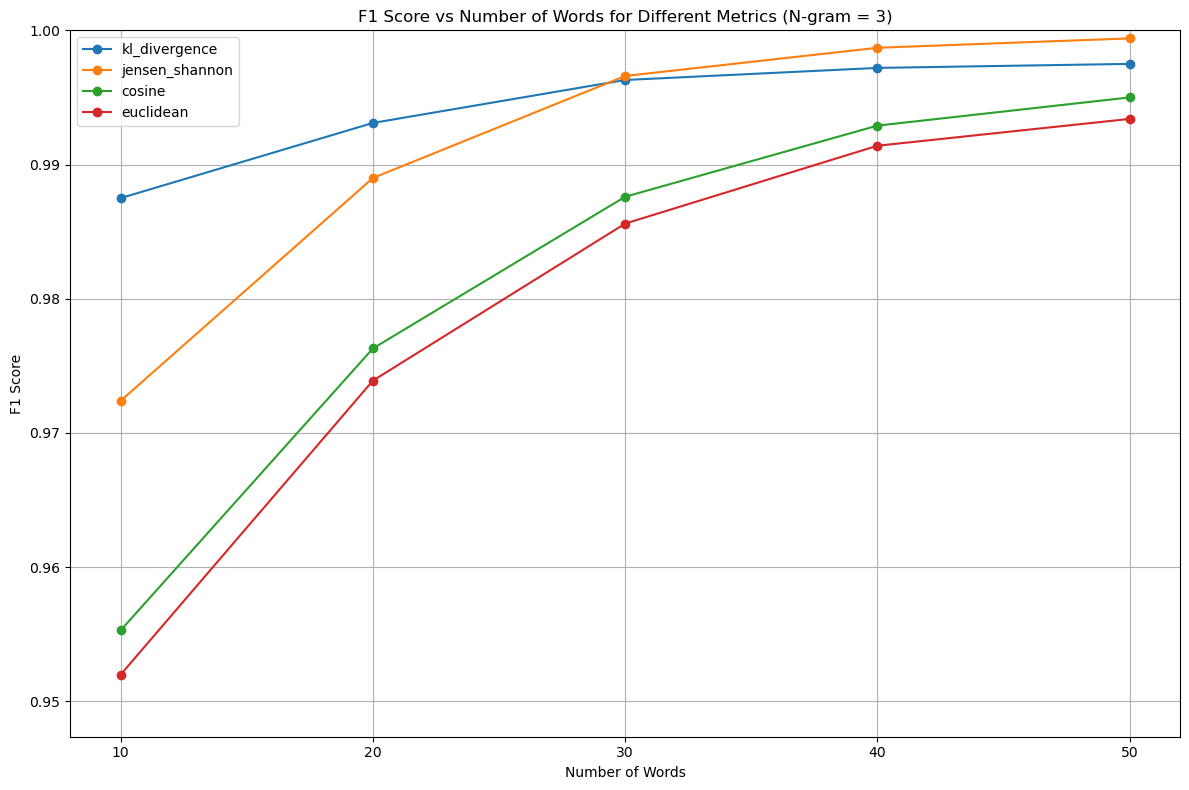

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def read_data_from_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                'n_gram': int(parts[0].split(': ')[1]),
                'metric': parts[1].split(': ')[1],
                'n_words': int(parts[2].split(': ')[1]),
                'accuracy': float(parts[3].split(': ')[1]),
                'f1_score': float(parts[4].split(': ')[1])
            }
            data.append(entry)
    return data

def filter_and_average_data(data, filter_params):
    filtered_data = defaultdict(lambda: defaultdict(list))
    for entry in data:
        if all(entry[key] == value for key, value in filter_params.items()):
            filtered_data[entry['metric']][entry['n_words']].append(entry['f1_score'])
    
    averaged_data = {
        metric: {n_words: np.mean(scores) for n_words, scores in word_data.items()}
        for metric, word_data in filtered_data.items()
    }
    return averaged_data

def plot_f1_scores(data, title):
    plt.figure(figsize=(12, 8))
    
    for metric, scores in data.items():
        n_words = sorted(scores.keys())
        f1_scores = [scores[w] for w in n_words]
        plt.plot(n_words, f1_scores, marker='o', label=metric)
    
    plt.xlabel('Number of Words')
    plt.ylabel('F1 Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
    all_scores = [score for metric_scores in data.values() for score in metric_scores.values()]
    plt.ylim(np.floor(min(all_scores) * 10) / 9.5, np.ceil(max(all_scores) * 10) / 10)
    
    plt.xticks(sorted(set(n_words for scores in data.values() for n_words in scores.keys())))
    
    plt.tight_layout()
    plt.show()

# Read data from file
filename = 'evaluation_log.txt'  # Replace with your actual filename
data = read_data_from_file(filename)

# Example: Plot F1 scores for n-gram = 3
filtered_data = filter_and_average_data(data, {'n_gram': 3})
plot_f1_scores(filtered_data, 'F1 Score vs Number of Words for Different Metrics (N-gram = 3)')

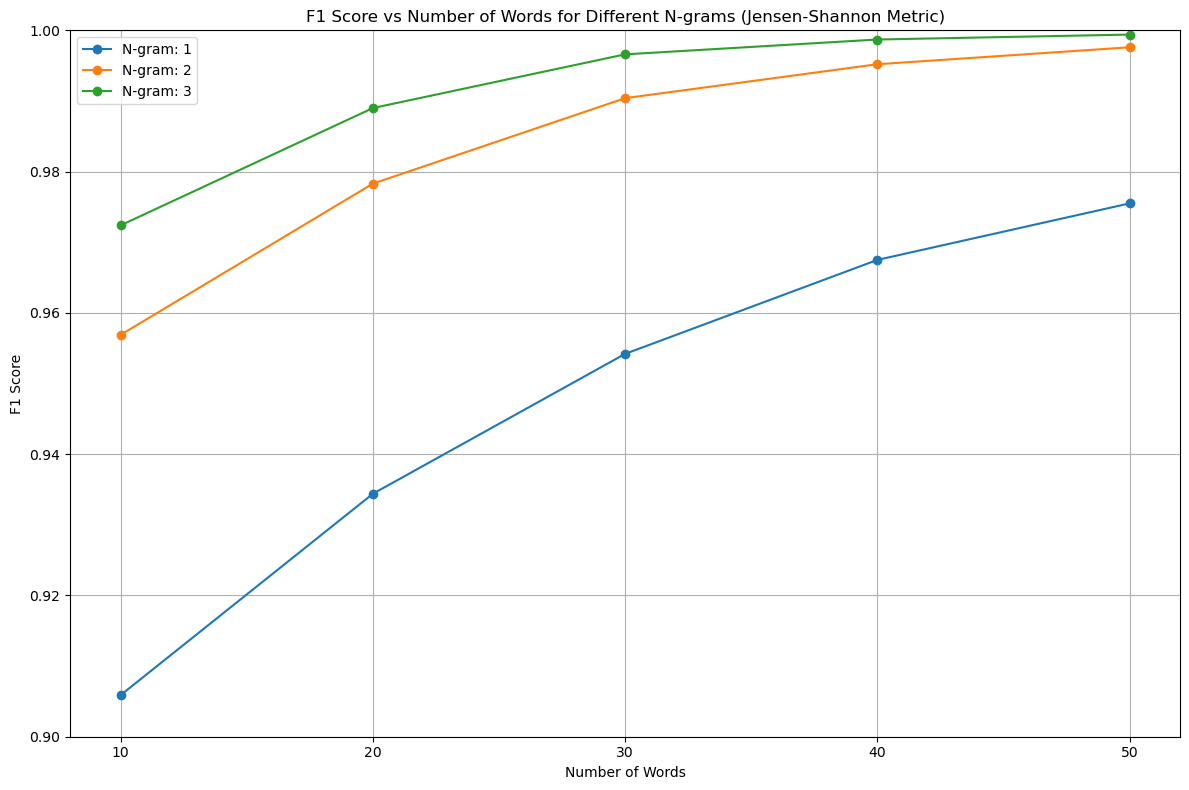

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def read_data_from_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                'n_gram': int(parts[0].split(': ')[1]),
                'metric': parts[1].split(': ')[1],
                'n_words': int(parts[2].split(': ')[1]),
                'accuracy': float(parts[3].split(': ')[1]),
                'f1_score': float(parts[4].split(': ')[1])
            }
            data.append(entry)
    return data

def filter_and_average_data(data, filter_params):
    filtered_data = defaultdict(lambda: defaultdict(list))
    for entry in data:
        if all(entry[key] == value for key, value in filter_params.items()):
            filtered_data[entry['n_gram']][entry['n_words']].append(entry['f1_score'])
    
    averaged_data = {
        n_gram: {n_words: np.mean(scores) for n_words, scores in word_data.items()}
        for n_gram, word_data in filtered_data.items()
    }
    return averaged_data

# Read data from file
filename = 'evaluation_log.txt'  # Replace with your actual filename
data = read_data_from_file(filename)

# Filter data for Jensen-Shannon metric
jensen_shannon_data = filter_and_average_data(data, {'metric': 'jensen_shannon'})

# Create the plot
plt.figure(figsize=(12, 8))

for n_gram, scores in jensen_shannon_data.items():
    n_words = sorted(scores.keys())
    f1_scores = [scores[w] for w in n_words]
    plt.plot(n_words, f1_scores, marker='o', label=f'N-gram: {n_gram}')

plt.xlabel('Number of Words')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Words for Different N-grams (Jensen-Shannon Metric)')
plt.legend()
plt.grid(True)

all_scores = [score for gram_scores in jensen_shannon_data.values() for score in gram_scores.values()]
plt.ylim(np.floor(min(all_scores) * 10) / 10, np.ceil(max(all_scores) * 10) / 10)

plt.xticks(sorted(set(n_words for scores in jensen_shannon_data.values() for n_words in scores.keys())))

plt.tight_layout()
plt.show()